In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'image-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F55098%2F107188%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240327%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240327T154634Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D85070050ff7f18ba28567a639e4f25964b48853e556d208a9fea4458a1a8694bd7dd194c068f1c02cb5ed69d5afbd0f21f6a6400f362ca70f86f65de3aa4c6f26010bb2a875504e4dc0d835fd0c0cb52a600c068a5b4decad1df7677d2affded068660d7df4d2ea489f9084e4334a9e758ec488f5516bc6c5c947a82a670382a2d36703541d0d9e53f7995614d2c1d1d42d037fb78e3f56e088c7bd2b7e7ae2042e81d4fd5149c3cfaa04a53f6f6065877b313eaab41866eeff12b556ab11aceb758bb8c5db08734b8830e5ab071bdb9b14cb82f9c12904f0e5198aa7122291cca724d994a42b7f6591f6e3f945c9482891b54a3b8cf37804b8477bf4f46b6ee,impressionist-classifier-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F568245%2F1031162%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240327%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240327T154634Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D674b655e26a7cd3f40a35626b3369b212b2fbec24207a2dd9c33b76ee9439564580f1dd39ea9930832e9e96882037613c9a1ab091d32ee64b979179485d9982c38d2d587a7802afe16d0d66d9c26aabec3b0340a3de34a08c17bda68c23db2a872717aa95f510ed1599eb7b18a446cc8feb1f82de241b2268d5e8b69fddae44f22f8585bf2da01857f0b703d6cc244b976ef03a7126d06bbe355f96af0584254b9588efaff06dc9aa64d3d35db482bda3fe553a9243801b8e074c8144e05afa9e872f8ee2f7085af72fa83baca45942577910d7c178579df03c4e0d5f2e9d6932e5346e02918ac73d1f2cdb3329a0cea5f93330f2edb9548e2e170ee58cd0473'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2514186873 bytes downloaded
Downloaded and uncompressed: image-classification
[==================================================] 2346975634 bytes downloaded
Downloaded and uncompressed: impressionist-classifier-data
Data source import complete.


In [2]:
!pip install keras.utils

#GENERAL
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
#PATH PROCESS
import os
import os.path
from pathlib import Path
import glob
#IMAGE PROCESS
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import imageio
from IPython.display import Image
import matplotlib.image as mpimg
from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import zipfile
from io import BytesIO
from nibabel import FileHolder
from nibabel.analyze import AnalyzeImage
#SCALER & TRANSFORMATION
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical  # Adjusted import
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
#ACCURACY CONTROL
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
#OPTIMIZER
from keras.optimizers import RMSprop, Adam, SGD  # Adjusted import
#MODEL LAYERS
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D  # Adjusted import


  Preparing metadata (setup.py) ... done
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2631 sha256=d454254a0ea1cb352dbe9741fc53d104bc6e390ccbc2d7d2c30536688c05b86e
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras.utils


In [3]:
Architecure_Data = Path("../input/image-classification/images/images/architecure")
Cezanne_Data = Path("../input/impressionist-classifier-data/training/training/Cezanne")
Main_JPG_Path = list(Architecure_Data.glob(r"*.jpg"))
Cezanne_JPG_Path = list(Cezanne_Data.glob(r"*.jpg"))
for Cezanne_IMG in Cezanne_JPG_Path:
    Main_JPG_Path.append(Cezanne_IMG)
Main_JPG_Series = pd.Series(Main_JPG_Path,name="JPG").astype(str)
print(Main_JPG_Series.head(-1))

0       ../input/image-classification/images/images/ar...
1       ../input/image-classification/images/images/ar...
2       ../input/image-classification/images/images/ar...
3       ../input/image-classification/images/images/ar...
4       ../input/image-classification/images/images/ar...
                              ...                        
9156    ../input/impressionist-classifier-data/trainin...
9157    ../input/impressionist-classifier-data/trainin...
9158    ../input/impressionist-classifier-data/trainin...
9159    ../input/impressionist-classifier-data/trainin...
9160    ../input/impressionist-classifier-data/trainin...
Name: JPG, Length: 9161, dtype: object


In [4]:
Main_JPG_Series = Main_JPG_Series.sample(frac=1).reset_index(drop=True)
print(Main_JPG_Series.head(-1))

0       ../input/image-classification/images/images/ar...
1       ../input/image-classification/images/images/ar...
2       ../input/image-classification/images/images/ar...
3       ../input/image-classification/images/images/ar...
4       ../input/image-classification/images/images/ar...
                              ...                        
9156    ../input/image-classification/images/images/ar...
9157    ../input/image-classification/images/images/ar...
9158    ../input/image-classification/images/images/ar...
9159    ../input/impressionist-classifier-data/trainin...
9160    ../input/image-classification/images/images/ar...
Name: JPG, Length: 9161, dtype: object


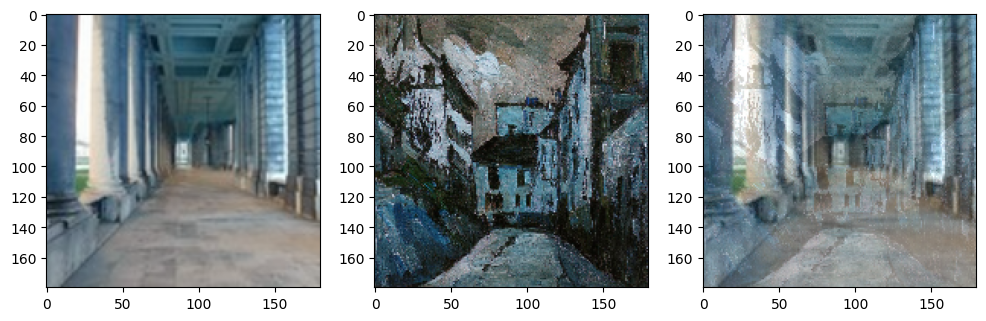

In [5]:
Cezanne_IMG_Data = pd.Series(list(Cezanne_Data.glob(r"*.jpg")),name="JPG").astype(str)
Architecure_IMG_Data = pd.Series(list(Architecure_Data.glob(r"*.jpg")),name="JPG").astype(str)
Example_Arc_IMG = Architecure_IMG_Data[440]
Example_Cezanne_IMG = Cezanne_IMG_Data[2]
Reading_Arc = cv2.imread(Example_Arc_IMG)
Reading_Arc = cv2.resize(Reading_Arc,(180,180))
Reading_Cezanne = cv2.imread(Example_Cezanne_IMG)
Reading_Cezanne = cv2.resize(Reading_Cezanne,(180,180))
figure,axis = plt.subplots(1,3,figsize=(12,12))

Blend_IMG = cv2.addWeighted(Reading_Arc,0.8,Reading_Cezanne,0.4,0.5)

axis[0].imshow(Reading_Arc)
axis[1].imshow(Reading_Cezanne)
axis[2].imshow(Blend_IMG)

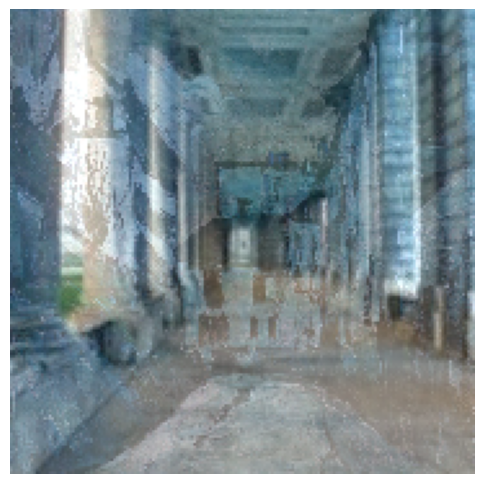

In [6]:
figure = plt.figure(figsize=(6,12))
plt.axis("off")
plt.imshow(Blend_IMG)

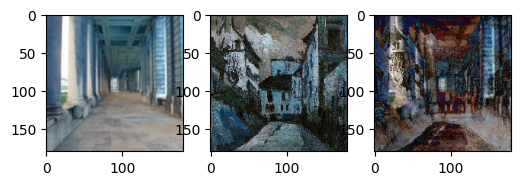

In [7]:
figure,axis = plt.subplots(1,3,figsize=(6,12))

Diff_IMG = cv2.absdiff(Reading_Arc,Reading_Cezanne,np.zeros((5,5)))

axis[0].imshow(Reading_Arc)
axis[1].imshow(Reading_Cezanne)
axis[2].imshow(Diff_IMG)

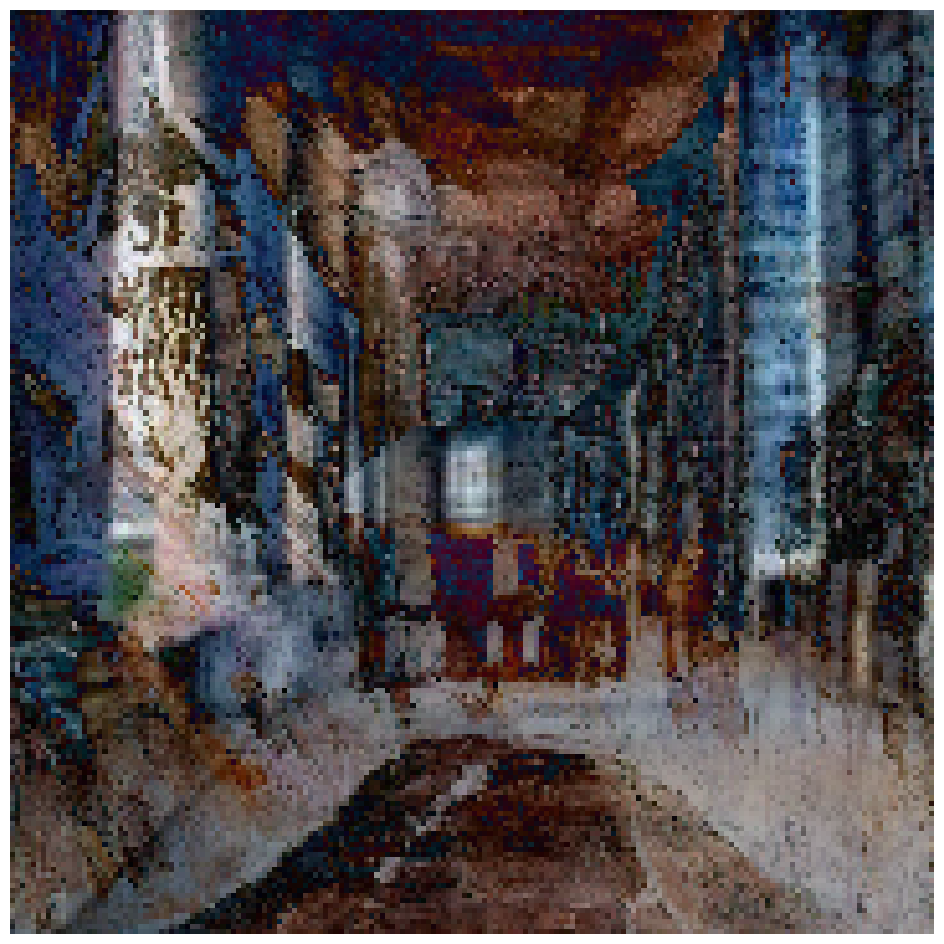

In [8]:
figure = plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(Diff_IMG)

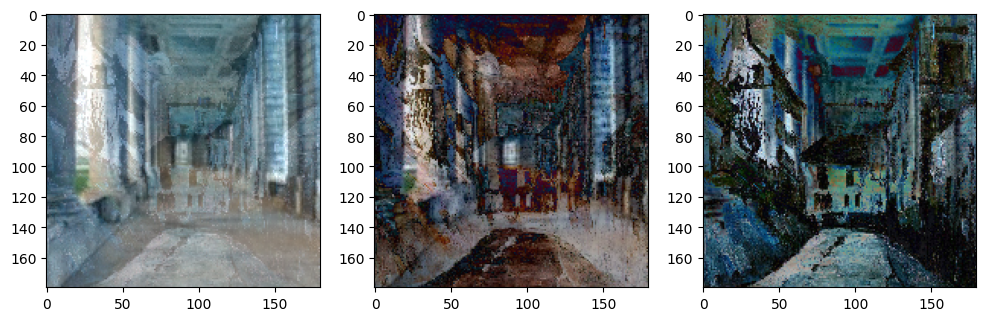

In [9]:
figure,axis = plt.subplots(1,3,figsize=(12,12))

Diff_Concat = cv2.absdiff(Diff_IMG,Blend_IMG,np.zeros((5,5)))

axis[0].imshow(Blend_IMG)
axis[1].imshow(Diff_IMG)
axis[2].imshow(Diff_Concat)

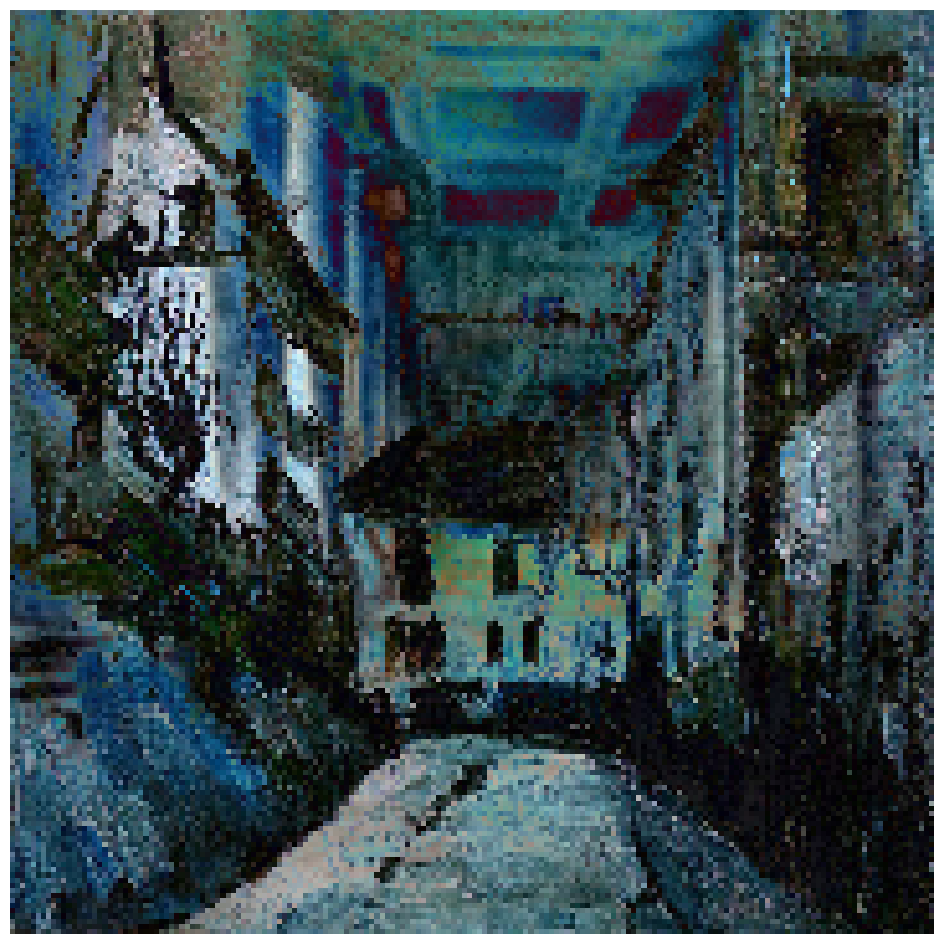

In [10]:
figure = plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(Diff_Concat)

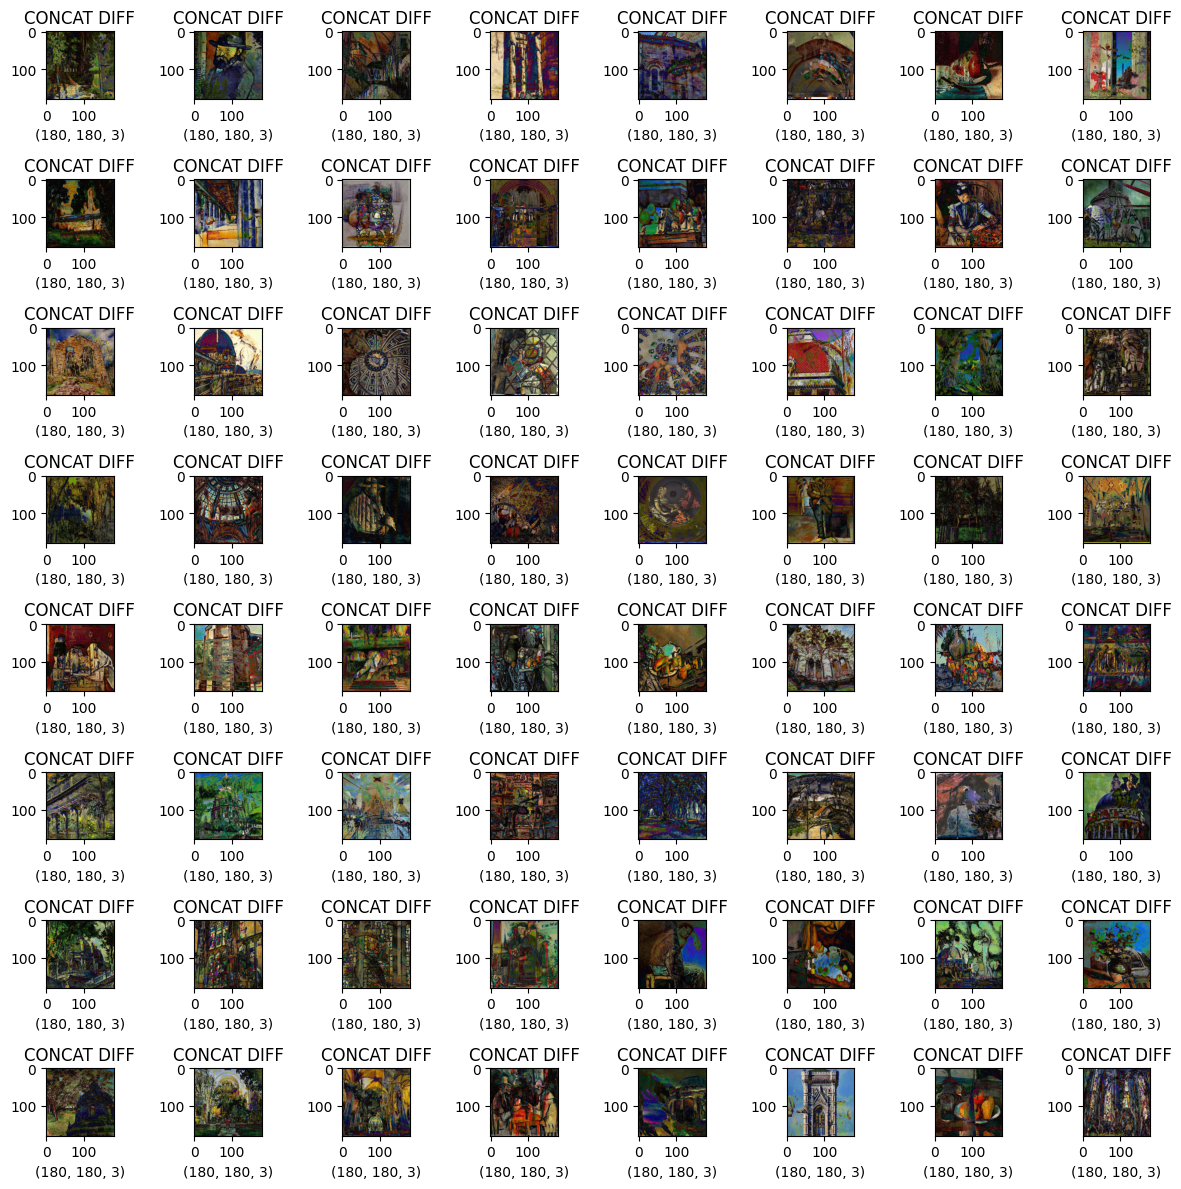

In [11]:
figure,axis = plt.subplots(8,8,figsize=(12,12))

list_diff_img = []

for i,ax in enumerate(axis.flat):
    IM_1 = Example_Arc_IMG = Architecure_IMG_Data[i]
    IM_2 = Example_Cezanne_IMG = Cezanne_IMG_Data[i]
    Reading_Arc = cv2.imread(IM_1)
    Reading_Arc = cv2.cvtColor(Reading_Arc,cv2.COLOR_BGR2RGB)
    Reading_Arc = cv2.resize(Reading_Arc,(180,180))
    Reading_Cezanne = cv2.imread(IM_2)
    Reading_Cezanne = cv2.cvtColor(Reading_Cezanne,cv2.COLOR_BGR2RGB)
    Reading_Cezanne = cv2.resize(Reading_Cezanne,(180,180))
    Blend_IMG = cv2.addWeighted(Reading_Arc,0.8,Reading_Cezanne,0.3,0.5)
    Diff_IMG = cv2.absdiff(Reading_Arc,Reading_Cezanne,np.zeros((5,5)))
    Diff_Concat = cv2.absdiff(Diff_IMG,Blend_IMG,np.zeros((5,5)))

    list_diff_img.append(Diff_Concat)

    ax.set_xlabel(Diff_Concat.shape)
    ax.set_title("CONCAT DIFF")
    ax.imshow(Diff_Concat)

plt.tight_layout()
plt.show()

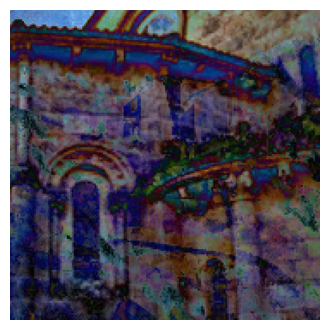

In [12]:
figure = plt.figure(figsize=(4,12))
plt.axis("off")
plt.imshow(list_diff_img[4])

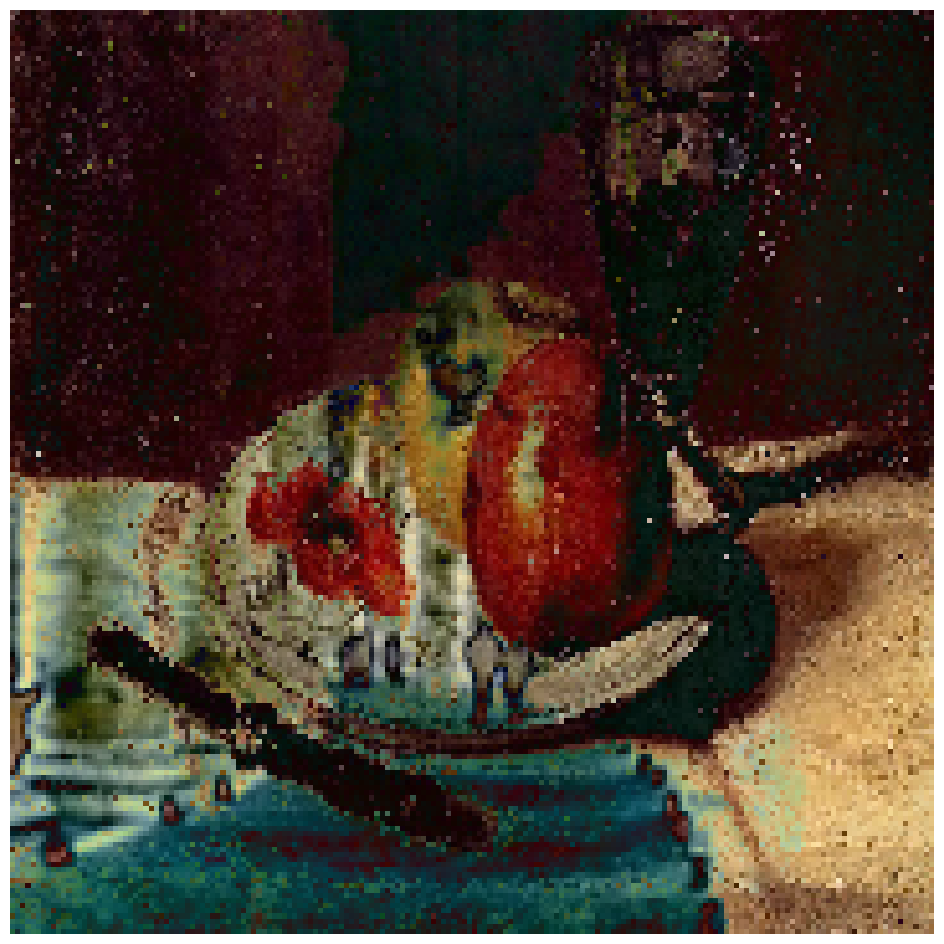

In [13]:
figure = plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(list_diff_img[6])

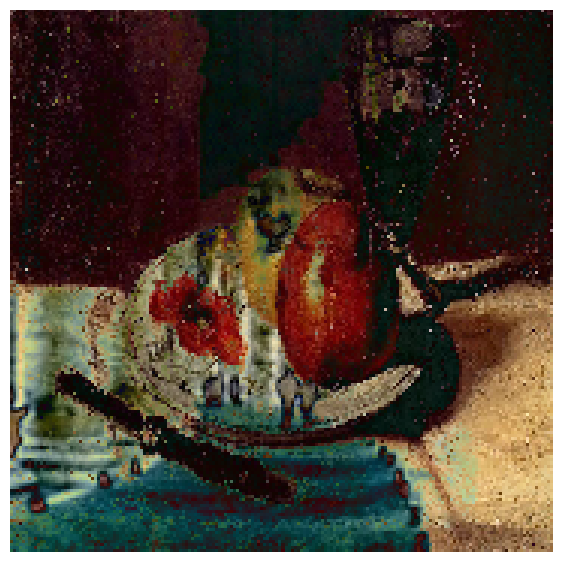

In [14]:
figure = plt.figure(figsize=(7,12))
plt.axis("off")
plt.imshow(list_diff_img[6])

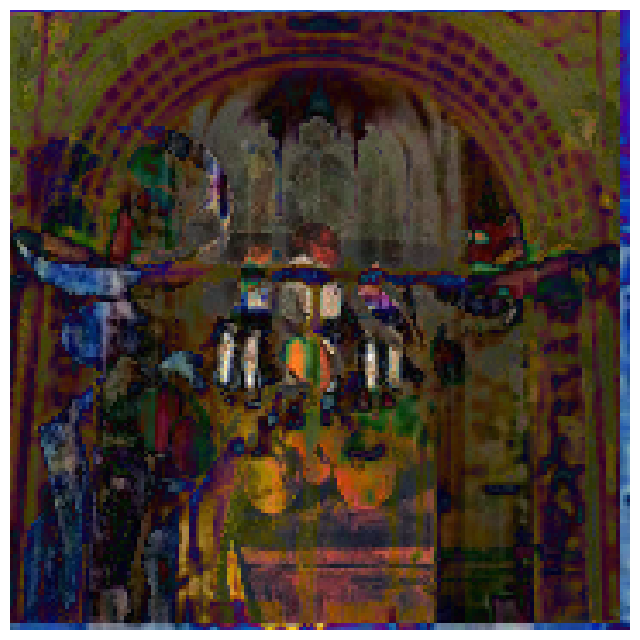

In [15]:
figure = plt.figure(figsize=(8,12))
plt.axis("off")
plt.imshow(list_diff_img[11])

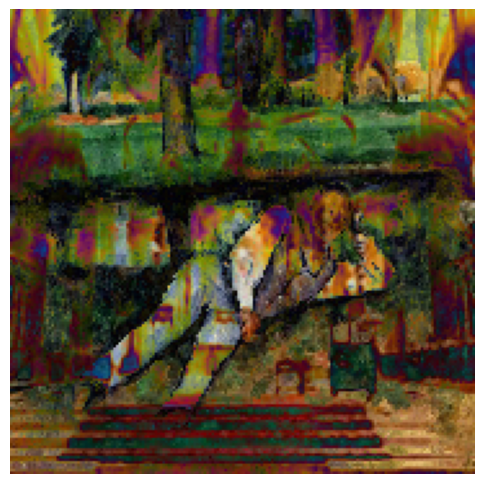

In [16]:
figure = plt.figure(figsize=(6,12))
plt.axis("off")
plt.imshow(list_diff_img[34])

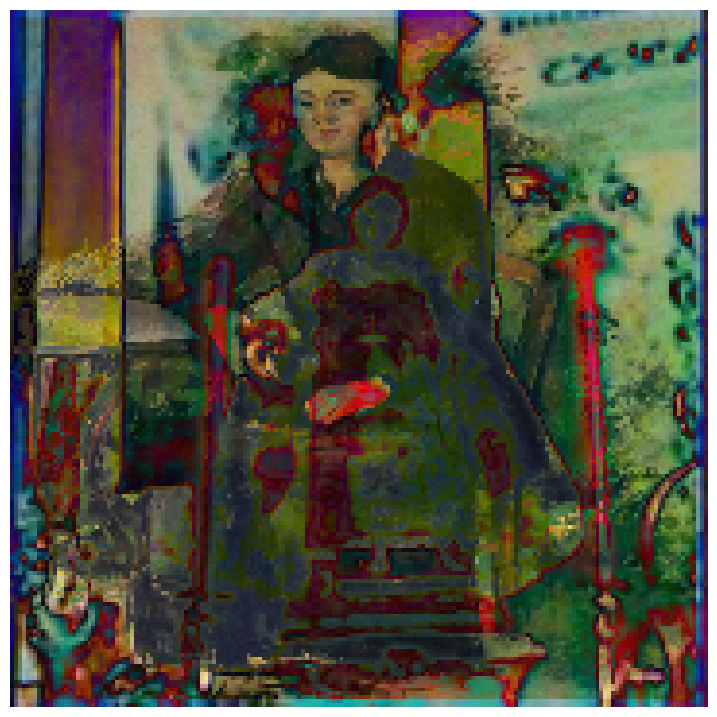

In [17]:
figure = plt.figure(figsize=(9,12))
plt.axis("off")
plt.imshow(list_diff_img[51])

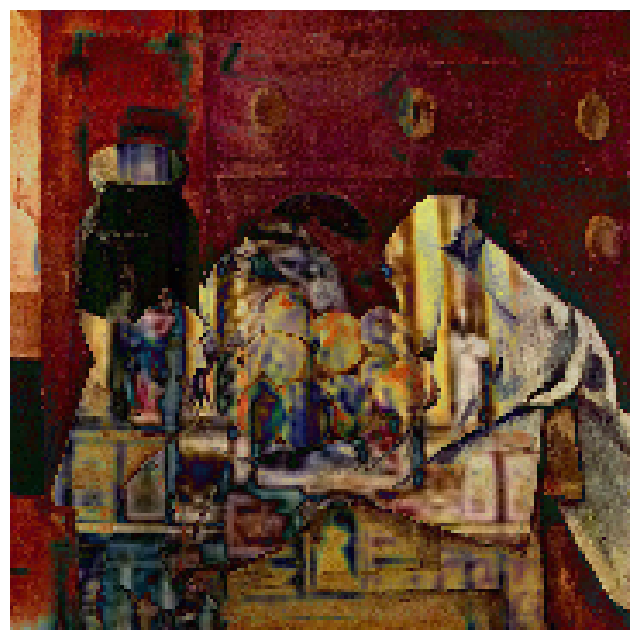

In [18]:
figure = plt.figure(figsize=(8,12))
plt.axis("off")
plt.imshow(list_diff_img[32])

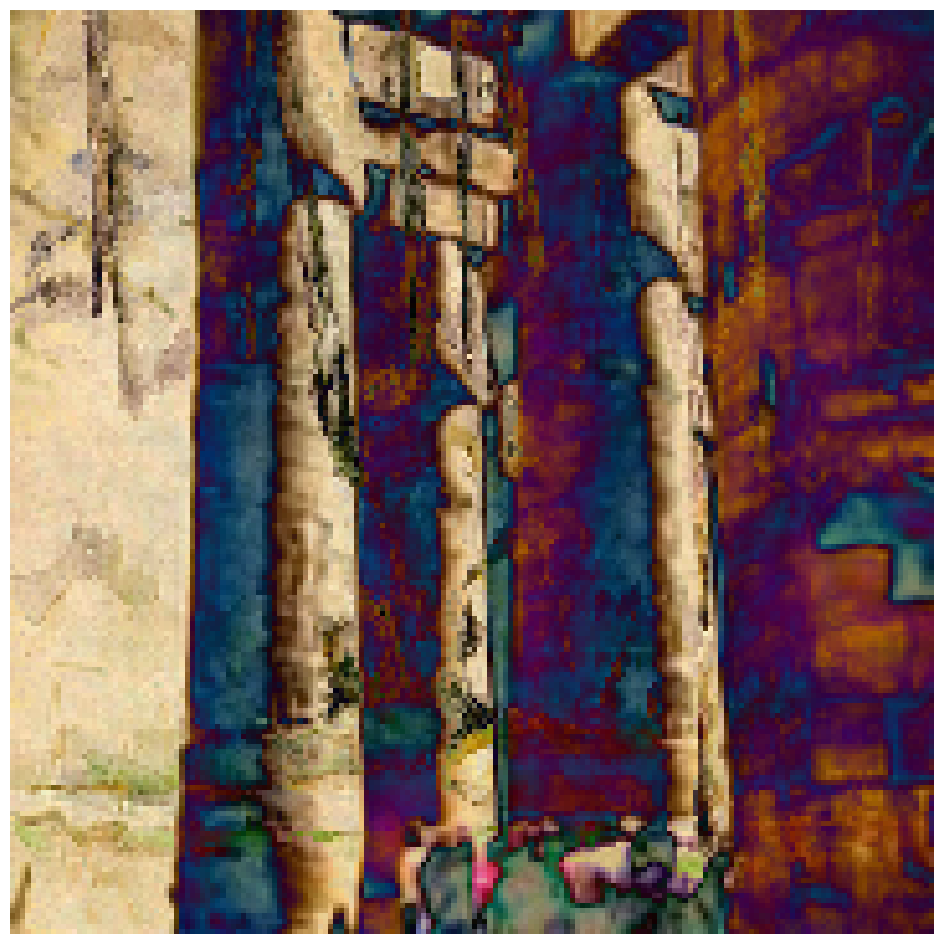

In [19]:
figure = plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(list_diff_img[3])

In [20]:
Splitting_Data = Main_JPG_Series[2000:4000]
X_Train = []

for IMG_main in Splitting_Data:
    X_IMG = cv2.imread(IMG_main)
    X_IMG = cv2.cvtColor(X_IMG,cv2.COLOR_BGR2RGB)
    X_IMG = cv2.resize(X_IMG,(180,180))
    X_IMG = X_IMG / 255.
    X_Train.append(X_IMG)

print("IT'S TRANSFORMED")

IT'S TRANSFORMED


In [21]:
print(X_Train[3].shape)

(180, 180, 3)


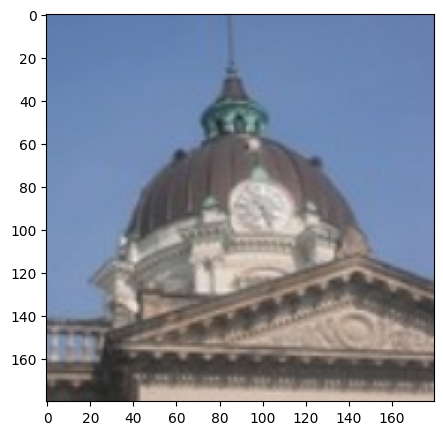

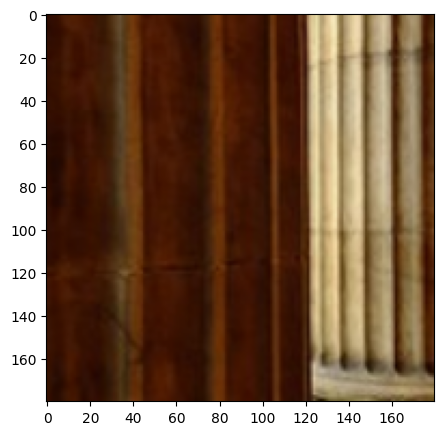

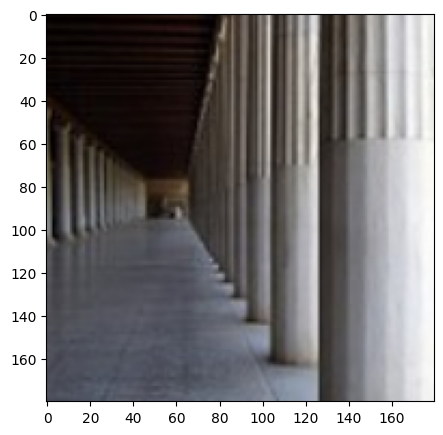

In [22]:
figure = plt.figure(figsize=(5,10))
plt.imshow(X_Train[3])


figure = plt.figure(figsize=(5,10))
plt.imshow(X_Train[100])


figure = plt.figure(figsize=(5,10))
plt.imshow(X_Train[1000])


In [23]:
X_Train = np.asarray(X_Train)
X_Train = X_Train.reshape(-1,180,180,3)
print(X_Train.shape)

(2000, 180, 180, 3)


In [24]:

!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
Generator_Input = keras.Input(shape=(180,))

x = layers.Dense(128*90*90)(Generator_Input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((90,90,128))(x)

x = layers.Conv2D(256,4,padding="same")(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256,4,padding="same",strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256,4,padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256,3,padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256,3,padding="same")(x)
x = layers.LeakyReLU()(x)


x = layers.Conv2D(3,7,padding="same",activation="tanh")(x)
Generator = keras.models.Model(Generator_Input,x)
print(Generator.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180)]             0         
                                                                 
 dense (Dense)               (None, 1036800)           187660800 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1036800)           0         
                                                                 
 reshape (Reshape)           (None, 90, 90, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 90, 90, 256)       524544    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 90, 90, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 180, 180, 256)     104883

In [25]:
Discriminator_Input = layers.Input(shape=(180,180,3))

x = layers.Conv2D(128,3)(Discriminator_Input)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128,4,strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128,4,strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128,3,strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)
x = layers.Dense(1,activation="sigmoid")(x)

Discriminator = keras.models.Model(Discriminator_Input,x)
print(Discriminator.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 128)     3584      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 178, 178, 128)     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 88, 88, 128)       262272    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 88, 88, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 43, 43, 128)       262272    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 43, 43, 128)       0   

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

# Define the discriminator
Discriminator = keras.models.Sequential()
Discriminator.add(layers.Dense(128, input_dim=180, activation="relu"))
Discriminator.add(layers.Dense(1, activation="sigmoid"))
Discriminator.compile(optimizer=RMSprop(learning_rate=0.0008, clipvalue=1.0), loss="binary_crossentropy")
Discriminator.trainable = False

# Define the generator
Generator = keras.models.Sequential()  # Define your generator model here

# Define the DCGAN model
DCGAN_Input = keras.Input(shape=(180,))
Generated_Image = Generator(DCGAN_Input)
Validity = Discriminator(Generated_Image)
DCGAN_Model = keras.models.Model(DCGAN_Input, Validity)

# Compile the DCGAN model
DCGAN_Model.compile(optimizer=RMSprop(learning_rate=0.0001, clipvalue=1.0), loss="binary_crossentropy")

# Print the model summary
print(DCGAN_Model.summary())


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180)]             0         
                                                                 
 sequential_1 (Sequential)   multiple                  0         
                                                                 
 sequential (Sequential)     (None, 1)                 23297     
                                                                 
Total params: 23297 (91.00 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23297 (91.00 KB)
_________________________________________________________________
None


In [27]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'art-portraits:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1698586%2F2782287%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240328%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240328T034824Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D550d6dd487dd8635f2b3577a1e1124040cd8a292bd81ea2f505a547114ec2c463f21330f9977e3aed40ab3f1ae29c6d37d7b4353ee319fba237359b709bc689ad343671a1d931416e8dbcf4230bc707972c02f922869398d31fa709cba558b7d62863f7d0f0da6d152e04654aedab4a205b347fa2f10854ffab66340e4ddeb3f12a0481b7028cf50dd8d28f99275946986f578fef6f73f72eb8298080b19e213fde3dc28f784785c24b47a5b6b0b8019d1943b630f0b5f063657051c57b25e581f5a7fd0f2c23cf6349d62b8e2ee001e737b9827ab6df6878d18a35b0b850dd9ca27f79cebd64455c50418a47582e564b6945308d4cb028289dc20069390ec12'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1397698045 bytes downloaded
Downloaded and uncompressed: art-portraits
Data source import complete.


In [28]:
for dirname, _, filenames in os.walk("../input/art-portraits/Portraits/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/art-portraits/Portraits/7c7457dbc01d9083147eac40aa33bb36c.jpg
../input/art-portraits/Portraits/b7c2fdd9bb5d18a3c9d0c818a02b40b8c.jpg
../input/art-portraits/Portraits/c11e063b8c7659614fd90ff78984ecbac.jpg
../input/art-portraits/Portraits/27db3a3a4e0e508a66bec5f8f3a9e7aac.jpg
../input/art-portraits/Portraits/b412aa39eaac3f76d409356ea322b525c.jpg
../input/art-portraits/Portraits/6b5b7383683ec7c086ca125a29ba8725c.jpg
../input/art-portraits/Portraits/c66e194e4b41ef467005900e3dc4cc8fc.jpg
../input/art-portraits/Portraits/07db73198fa80660412b25003b0745e5c.jpg
../input/art-portraits/Portraits/7be496b093a8a04015305565ad5aaac0c.jpg
../input/art-portraits/Portraits/8fc07e264a9d7a4cff2aa5863e6050e9c.jpg
../input/art-portraits/Portraits/7a506c4ecb37a95823bd228e5b905a44c.jpg
../input/art-portraits/Portraits/ba903a5910e4f564f0deb3c0326bc33bc.jpg
../input/art-portraits/Portraits/fd299219ff968efd1bfce548327e821fc.jpg
../input/art-portraits/Portraits/e512a73f59331bcf41db32c7e51e59e2c.jpg
../inp

In [29]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
np.random.seed(42)

In [30]:
#Importing Libraries
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")
#Settings
sns.set(rc={"axes.facecolor":"#EDE9DE","figure.facecolor":"#D8CA7E"})

In [31]:
#Importing data
data_path = "../input/art-portraits/Portraits/"
batch_s = 64
#Import as tf.Dataset
data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 4117 files belonging to 1 classes.


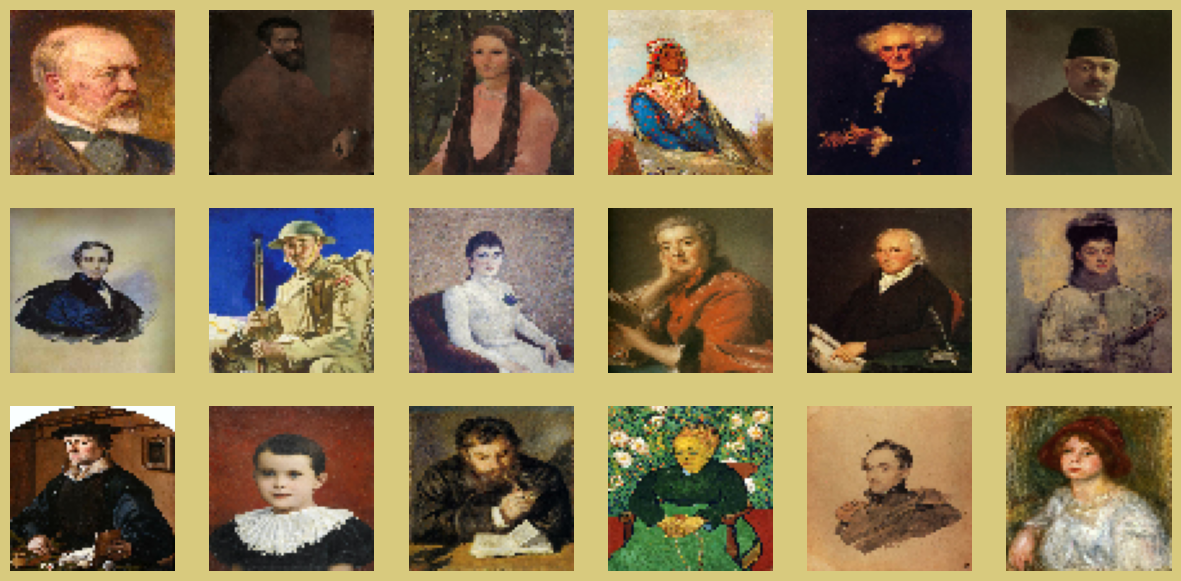

In [32]:
#Defing a function to see images
def Show_Img(data):
    plt.figure(figsize=(15,15))
    for images in data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")
#Plotting the images in dataset
Show_Img(data)

In [33]:
data = data.map(lambda x: x / 255.0)
data

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [34]:
latent_dim = 100
g_resolution=2

#Building a Generator
generator = Sequential()
generator.add(Dense(4*4*256,activation="relu",input_dim=latent_dim))
generator.add(Reshape((4,4,256)))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))#
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(3,kernel_size=3,padding="same"))
generator.add(Activation("tanh"))

generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4096)              413696    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 8, 8, 256)         0         
 D)                                                              
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization (Batch  (None, 8, 8, 256)         1024      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 8, 8, 256)        

(-0.5, 63.5, 63.5, -0.5)

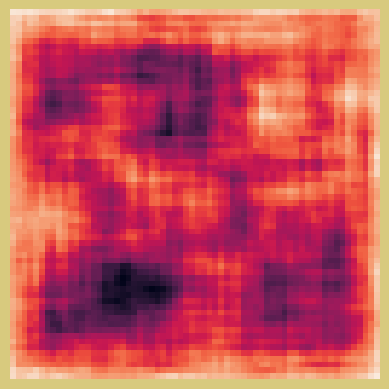

In [35]:
#Creating a random seed and output from generator
seed = tf.random.normal([1, latent_dim])
Generated_Portrait = generator(seed, training=False)
#Plotting the image output of generator without training
plt.imshow(Generated_Portrait[0, :, :, 0])
plt.axis("off")

In [36]:
#Building a Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d (ZeroPaddin  (None, 17, 17, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 17, 17, 64)        256       
 chNormalization)                                     

In [37]:
Discriminator_Verdict = discriminator(Generated_Portrait)
print (Discriminator_Verdict)

tf.Tensor([[0.5007491]], shape=(1, 1), dtype=float32)


In [38]:
#Code Sourced from keras sample. find the link in the Resorces below

class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [41]:
#Number of images to be generate
num_img=18

#A function to generate and save images
def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("Potraits{:02d}.png".format(i))
    return

#Generating images
Images = Potrait_Generator()

Text(0.5, 1.0, 'Learning Curve')

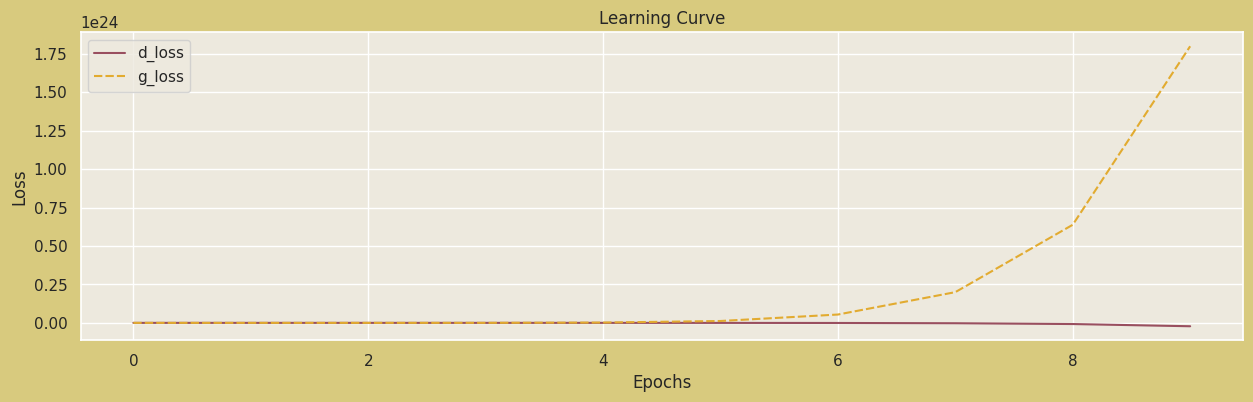

In [42]:

pal=["#994F5F","#E2AB30"]
#Plotting the learning curve
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
ax=sns.lineplot(data=history_df, palette= pal)
ax.set(xlabel ="Epochs")
ax.set(ylabel ="Loss")
ax.set_title("Learning Curve")



Found 18 files belonging to 1 classes.


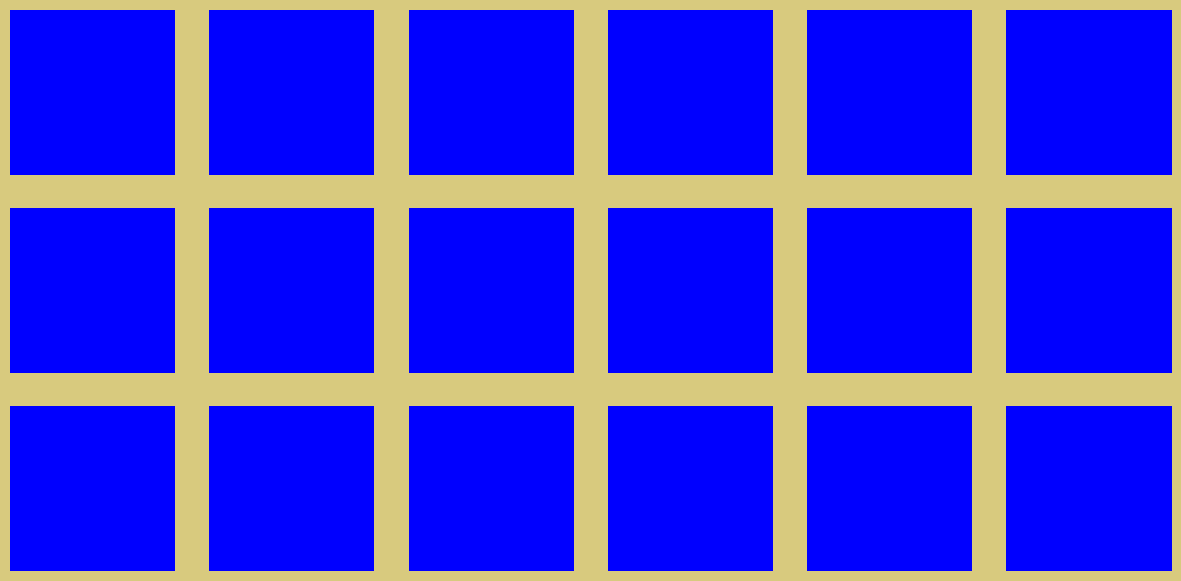

In [43]:
#Loading generated images
Generated_path = "./"
Potraits_generated = tf.keras.preprocessing.image_dataset_from_directory(Generated_path, label_mode = None)
#Plotting generated images
Show_Img(Potraits_generated)